# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

## Import packages

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD

from torchmin import minimize

## Data split
Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution

Graph the distribution of classes for each user

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
total_tr_len = len(cifar10_train)

X={}
Y=[]
for i in range(len(cifar10_train)):
    data = cifar10_train[i][0].numpy()
    label = cifar10_train[i][1]

    if label in X:
        X[label].append(data)
    else:
        X[label] = []
        X[label].append(data)
        Y.append(label)

for label in X:
    X[label] = np.array(X[label])
Y=np.array(Y)

alpha = 20
n_users = 50

In [5]:
user_train_data_non_tensors = [[] for _ in range(n_users)]
user_train_label_non_tensors = [[] for _ in range(n_users)]

for label in Y:
    alpha_list = [alpha for _ in range(n_users)]
    probs = np.random.dirichlet(alpha_list)

    taken_index = 0

    for i, prob in enumerate(probs):
        if i == n_users - 1:
            user_train_data_non_tensors[i].extend(X[label][taken_index:])
            user_train_label_non_tensors[i].extend([label for _ in range(len(X[label]) - taken_index)])
        else:
            n_sample = math.floor(prob * len(X[label]))

            user_train_data_non_tensors[i].extend(X[label][taken_index : taken_index + n_sample])
            user_train_label_non_tensors[i].extend([label for _ in range(n_sample)])
            taken_index += n_sample

user_train_data_tensors = []
user_train_label_tensors = []

user_tr_len = []

for i in range(n_users):

    if len(user_train_data_non_tensors[i]) != len(user_train_label_non_tensors[i]):
        sys.exit(f"Shape does not match user_train_data_non_tensors[i] hsa {len(user_train_data_non_tensors[i])}, while user_train_label_non_tensors[i] has {len(user_train_label_non_tensors[i])}")


    num_data = len(user_train_data_non_tensors[i])
    user_tr_len.append(num_data)

    user_train_data_tensors.append(torch.from_numpy(np.array(user_train_data_non_tensors[i])).type(torch.FloatTensor))
    user_train_label_tensors.append(torch.from_numpy(np.array(user_train_label_non_tensors[i])).type(torch.LongTensor))

    r=np.arange(num_data)

    np.random.shuffle(r)

    user_train_data_tensors[i] = user_train_data_tensors[i][r]
    user_train_label_tensors[i] = user_train_label_tensors[i][r]

    print(f'user {i} has {user_train_data_tensors[i].shape[0]} train data, and {user_train_label_tensors[i].shape[0]} train labels')



user 0 has 981 train data, and 981 train labels
user 1 has 935 train data, and 935 train labels
user 2 has 984 train data, and 984 train labels
user 3 has 973 train data, and 973 train labels
user 4 has 999 train data, and 999 train labels
user 5 has 1094 train data, and 1094 train labels
user 6 has 1074 train data, and 1074 train labels
user 7 has 1011 train data, and 1011 train labels
user 8 has 1083 train data, and 1083 train labels
user 9 has 900 train data, and 900 train labels
user 10 has 1004 train data, and 1004 train labels
user 11 has 920 train data, and 920 train labels
user 12 has 861 train data, and 861 train labels
user 13 has 964 train data, and 964 train labels
user 14 has 889 train data, and 889 train labels
user 15 has 1075 train data, and 1075 train labels
user 16 has 857 train data, and 857 train labels
user 17 has 1027 train data, and 1027 train labels
user 18 has 1042 train data, and 1042 train labels
user 19 has 961 train data, and 961 train labels
user 20 has 11

In [6]:
X2 = []
Y2 = []

for i in range(len(cifar10_test)):
    X2.append(cifar10_test[i][0].numpy())
    Y2.append(cifar10_test[i][1])

X2=np.array(X2)
Y2=np.array(Y2)

half_index = len(X2) // 2

val_data= X2[:half_index]
val_label= Y2[:half_index]

te_data=X2[half_index:]
te_label=Y2[half_index:]

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

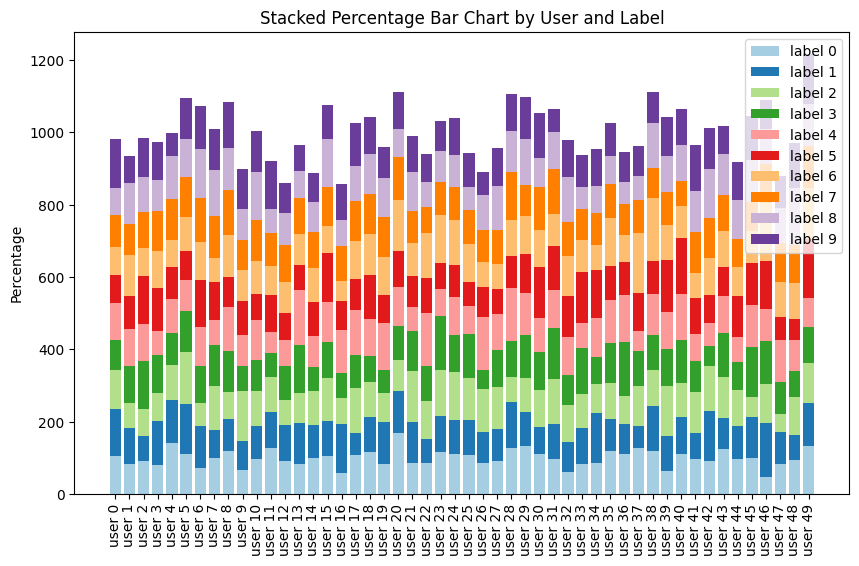

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Example data
users = [f"user {i}" for i in range(50)]
labels = [f"label {i}" for i in range(10)]


percentages = []
for user_data in user_train_label_non_tensors:
    temp_holder = []
    for label in range(10):
        temp_holder.append(user_data.count(label))
    percentages.append(temp_holder)

percentages = np.array(percentages)

# Assuming 'percentages' is populated correctly as shown previously
# Convert percentages to cumulative sum for stacking
cumulative = np.cumsum(percentages, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each ethnicity, ensuring there are enough colors for all labels
colors = plt.cm.Paired(range(len(labels))) # Repeating colors to match the number of labels

# Create stacked bars
for i in range(len(labels)):  # Iterate over the number of labels
    if i == 0:
        ax.bar(users, percentages[:, i], color=colors[i], label=labels[i])
    else:
        ax.bar(users, percentages[:, i], bottom=cumulative[:, i-1], color=colors[i], label=labels[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Stacked Percentage Bar Chart by User and Label')
ax.set_xticks(np.arange(len(users)))
ax.set_xticklabels(users, rotation=90)  # Rotate labels if needed
ax.legend()


plt.savefig('./non_iid_user_label_distribution.png', bbox_inches='tight')
plt.show()


## Our Aggregation Function

In [8]:
def our_mean_defense(all_updates, n_attackers, history_updates):
    # find the index of 10 users to be discarded
    discarded_history = []
    for _ in range(n_attackers):
        sum_of_distances = []
        for i, row in enumerate(history_updates):
            if i in discarded_history:
                sum_of_distances.append(-1)
                continue
            distance_sum = 0
            for j, other_row in enumerate(history_updates):
                if row != other_row and j not in discarded_history:
                    distance_sum += euclidean_distance(row, other_row)
            sum_of_distances.append(distance_sum)
        max_distance = max(sum_of_distances)
        index_of_max_distance = sum_of_distances.index(max_distance)
        discarded_history.append(index_of_max_distance)

    # get tensors in all_updates excluding the discarded ones
    mask = torch.ones(all_updates.size(0), dtype=torch.bool)  # Create a mask of ones (True)
    mask[discarded_history] = False  # Set indices in discarded_history to False
    remaining_updates = all_updates[mask]

    print('discarded index', discarded_history)

    # returns the mean of selected updates
    # after changing the attack, it should not have nan values
    return torch.nanmean(remaining_updates, dim=0)


def euclidean_distance(row1, row2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(row1, row2)))


## Code for no defense aggregation algorithm

In [9]:
def no_defense_aggregation(user_grads):
    return torch.nanmean(user_grads, dim=0)

## our_attack_mean
$ argmin_\theta(\ -L(\theta_{attacker(s)}) + \lambda_1 |\bar{\theta_{abs\ mean\ benige\ users}} - \bar{\theta_{abs\ attacker(s)}}|$

In [10]:
def check_condition(lambda1, model_grad, loss_grad, benign_abs_mean):
    new_model_grad = model_grad + lambda1 * loss_grad
    return abs(new_model_grad.abs().mean() - benign_abs_mean) <= benign_abs_mean / 10


def find_upper_bound(lambda1, model_grad, loss_grad, benign_abs_mean):
    while check_condition(lambda1, model_grad, loss_grad, benign_abs_mean):
        lambda1 *= 2  # Exponentially increase lambda
    return lambda1


def projection(model_grad, loss_grad, benign_abs_mean):
    lambda_low = 0
    lambda_high = find_upper_bound(1, model_grad, loss_grad, benign_abs_mean)
    tolerance = 1e-6

    while lambda_high - lambda_low > tolerance:
        lambda_mid = (lambda_low + lambda_high) / 2
        if check_condition(lambda_mid, model_grad, loss_grad, benign_abs_mean):
            lambda_low = lambda_mid + tolerance
        else:
            lambda_high = lambda_mid - tolerance

    lambda1 = lambda_mid - tolerance
    return model_grad + lambda1 * loss_grad


def our_attack_mean(all_updates, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors):
    all_updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)  # [50,1]
    benign_abs_mean_avg = all_updates_abs_mean.mean() # [1, 1]

    result_attacker_grads = []
    attacker_grads = all_updates[:n_attacker]

    for index, attacker_grad in enumerate(attacker_grads):

        attacker_tr_data_tensor = user_train_data_tensors[index].cuda()
        attacker_tr_label_tensor = user_train_label_tensors[index].cuda()

        fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)

        X = attacker_grad
        grads = []
        start_idx = 0
        for _, param in enumerate(fed_model.parameters()):
            param_=X[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            grads.append(param_)

        optimizer_fed = SGD(grads, lr=0.005)
        optimizer_fed.zero_grad()
        optimizer_fed.step(grads)

        outputs = fed_model(attacker_tr_data_tensor)
        loss = criterion(outputs, attacker_tr_label_tensor)

        optimizer_fed.zero_grad()
        loss.backward()

        param_grad=[]
        for param in fed_model.parameters():
            param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

        new_model_grad = projection(attacker_grad, param_grad, benign_abs_mean_avg)
        result_attacker_grads.append(new_model_grad)

    return torch.stack(result_attacker_grads).cuda()





## Set number of epochs

In [11]:
nepochs= 300

## Execute our attack + 10 attacker + our defense

In [13]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[0]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)

        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:   # No attack
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        for i in range(n_users):
            history[i].extend(updates_abs_mean[i].cpu())

        agg_grads = no_defense_aggregation(malicious_grads)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./our attack + 10 attacker + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

c:\Users\Hizan\Desktop\CPEN497-FL\CPEN497-499\sgd.py:109: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1630.)
  p.data.add_(-group['lr'], d_p)


epoch: 0, bulyan: at our-agr n_at 0 e 0 | val loss 2.3028 val acc 11.3433 best val_acc 11.343344


C:\Users\Hizan\AppData\Local\Temp\ipykernel_11040\789873353.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 0 e 1 | val loss 2.3024 val acc 13.3117 best val_acc 13.311688
epoch: 2, bulyan: at our-agr n_at 0 e 2 | val loss 2.3019 val acc 13.3726 best val_acc 13.372565
epoch: 3, bulyan: at our-agr n_at 0 e 3 | val loss 2.3014 val acc 15.1177 best val_acc 15.117695
epoch: 4, bulyan: at our-agr n_at 0 e 4 | val loss 2.3009 val acc 14.9351 best val_acc 15.117695
epoch: 5, bulyan: at our-agr n_at 0 e 5 | val loss 2.3004 val acc 15.5438 best val_acc 15.543831
epoch: 6, bulyan: at our-agr n_at 0 e 6 | val loss 2.2999 val acc 15.4018 best val_acc 15.543831
epoch: 7, bulyan: at our-agr n_at 0 e 7 | val loss 2.2993 val acc 15.5032 best val_acc 15.543831
epoch: 8, bulyan: at our-agr n_at 0 e 8 | val loss 2.2986 val acc 18.9123 best val_acc 18.912338
epoch: 9, bulyan: at our-agr n_at 0 e 9 | val loss 2.2979 val acc 18.4862 best val_acc 18.912338
epoch: 10, bulyan: at our-agr n_at 0 e 10 | val loss 2.2970 val acc 19.1761 best val_acc 19.176136
epoch: 11, bulyan: at our-ag

In [14]:
# ne = 304

# plt.figure(figsize=(10, 6))
# x = np.arange(ne)
# for i in range(40):
#     y = history[i+10]
#     plt.plot(x, y, color='green')

# for i in range(10):
#     y = history[i]
#     plt.plot(x, y, color='red')

# plt.title('history')
# plt.xlabel('epoch')
# plt.ylabel('mean')
# plt.legend()
# plt.grid(True)
# plt.show()

In [15]:
# import matplotlib.pyplot as plt
# import numpy as np

# ne =  304

# for j in range(10):
#   plt.figure(figsize=(10, 6))
#   x = np.arange(ne)
#   for i in range(40):
#       y = history[i+10]
#       plt.plot(x, y, color='green')

#   # for i in range(10):
#   #     y = history[i]
#   #     plt.plot(x, y, color='red')
#   y = history[j]
#   plt.plot(x, y, color='red')


#   plt.title('history')
#   plt.xlabel('epoch')
#   plt.ylabel('mean')
#   plt.legend()
#   plt.grid(True)
#   plt.savefig('./history_malicious_'+str(j)+'.png')
#   plt.show()

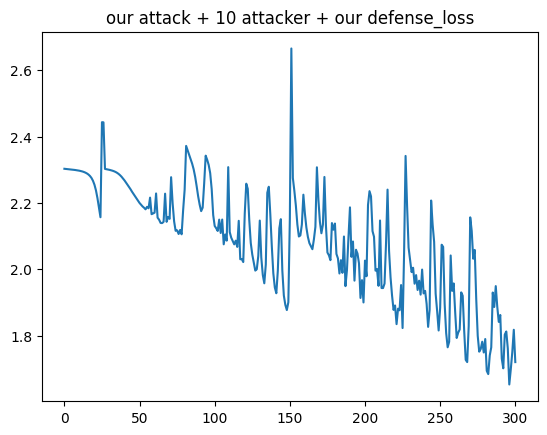

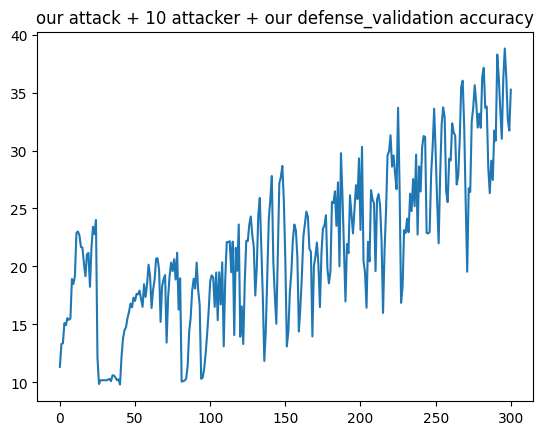

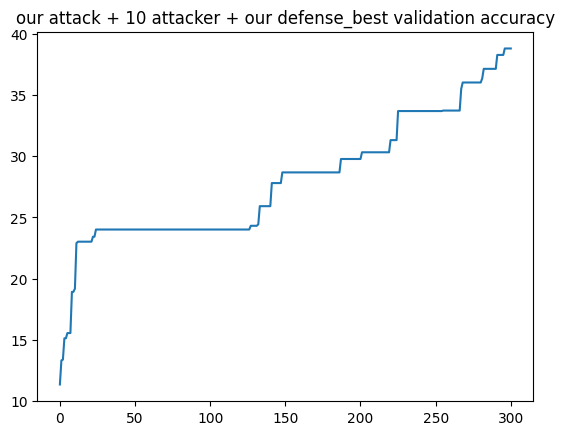

In [16]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./our attack + 0 attacker + no defense ' + col + '.png')
    plt.show()

In [17]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)

        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:   # No attack
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        for i in range(n_users):
            history[i].extend(updates_abs_mean[i].cpu())

        agg_grads = no_defense_aggregation(malicious_grads)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./our attack + 10 attacker + no defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

epoch: 0, bulyan: at our-agr n_at 10 e 0 | val loss 2.3021 val acc 10.2273 best val_acc 10.227273


C:\Users\Hizan\AppData\Local\Temp\ipykernel_11040\2049492293.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 10 e 1 | val loss 2.3015 val acc 10.2273 best val_acc 10.227273
epoch: 2, bulyan: at our-agr n_at 10 e 2 | val loss 2.3010 val acc 10.2273 best val_acc 10.227273
epoch: 3, bulyan: at our-agr n_at 10 e 3 | val loss 2.3005 val acc 10.2273 best val_acc 10.227273
epoch: 4, bulyan: at our-agr n_at 10 e 4 | val loss 2.3000 val acc 10.2273 best val_acc 10.227273
epoch: 5, bulyan: at our-agr n_at 10 e 5 | val loss 2.2994 val acc 10.2273 best val_acc 10.227273
epoch: 6, bulyan: at our-agr n_at 10 e 6 | val loss 2.2988 val acc 10.2273 best val_acc 10.227273
epoch: 7, bulyan: at our-agr n_at 10 e 7 | val loss 2.2980 val acc 10.4099 best val_acc 10.409903
epoch: 8, bulyan: at our-agr n_at 10 e 8 | val loss 2.2972 val acc 10.4099 best val_acc 10.409903
epoch: 9, bulyan: at our-agr n_at 10 e 9 | val loss 2.2963 val acc 11.2216 best val_acc 11.221591
epoch: 10, bulyan: at our-agr n_at 10 e 10 | val loss 2.2951 val acc 11.6071 best val_acc 11.607143
epoch: 11, bulyan:

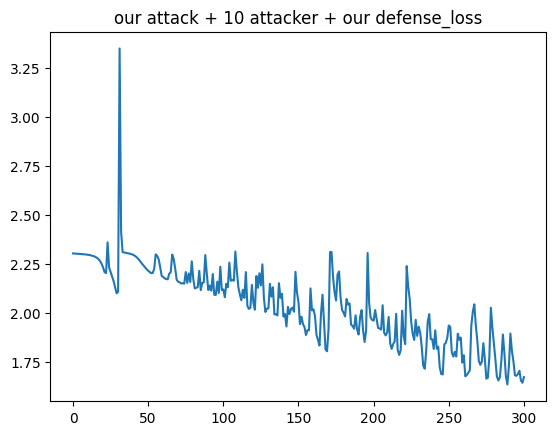

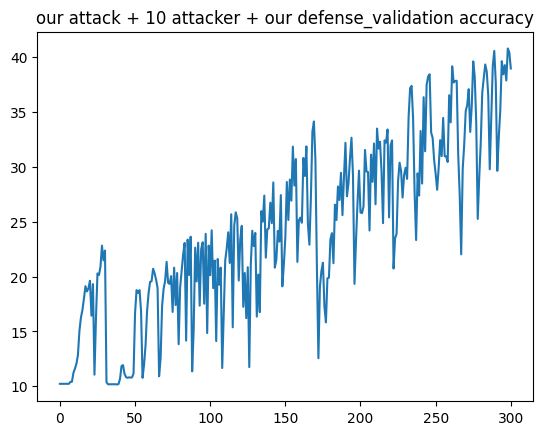

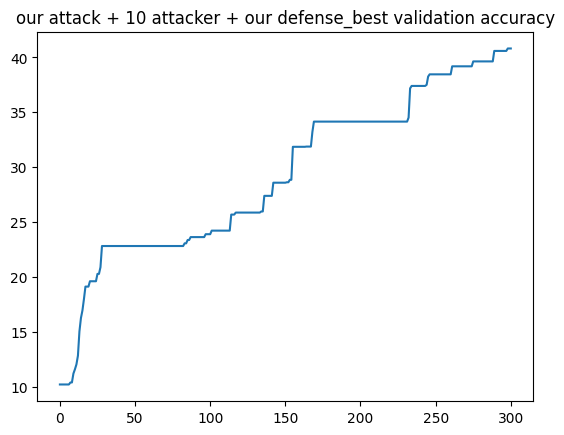

In [18]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./our attack + 10 attacker + our defense ' + col + '.png')
    plt.show()

In [19]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[40]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)

        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:   # No attack
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        for i in range(n_users):
            history[i].extend(updates_abs_mean[i].cpu())

        agg_grads = no_defense_aggregation(malicious_grads)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./our attack + 40 attacker + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

epoch: 0, bulyan: at our-agr n_at 40 e 0 | val loss 2.3030 val acc 9.8823 best val_acc 9.882305


C:\Users\Hizan\AppData\Local\Temp\ipykernel_11040\3797676870.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 40 e 1 | val loss 2.3025 val acc 9.8823 best val_acc 9.882305
epoch: 2, bulyan: at our-agr n_at 40 e 2 | val loss 2.3021 val acc 9.8823 best val_acc 9.882305
epoch: 3, bulyan: at our-agr n_at 40 e 3 | val loss 2.3016 val acc 9.8823 best val_acc 9.882305
epoch: 4, bulyan: at our-agr n_at 40 e 4 | val loss 2.3011 val acc 9.8823 best val_acc 9.882305
epoch: 5, bulyan: at our-agr n_at 40 e 5 | val loss 2.3006 val acc 9.8620 best val_acc 9.882305
epoch: 6, bulyan: at our-agr n_at 40 e 6 | val loss 2.3001 val acc 9.8823 best val_acc 9.882305
epoch: 7, bulyan: at our-agr n_at 40 e 7 | val loss 2.2995 val acc 10.2476 best val_acc 10.247565
epoch: 8, bulyan: at our-agr n_at 40 e 8 | val loss 2.2988 val acc 12.5406 best val_acc 12.540584
epoch: 9, bulyan: at our-agr n_at 40 e 9 | val loss 2.2980 val acc 14.7119 best val_acc 14.711851
epoch: 10, bulyan: at our-agr n_at 40 e 10 | val loss 2.2970 val acc 17.2890 best val_acc 17.288961
epoch: 11, bulyan: at our-agr 

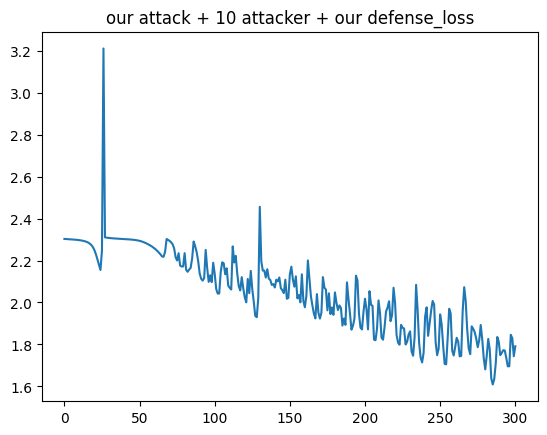

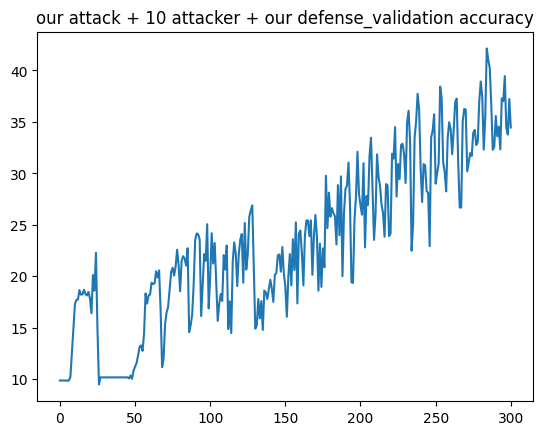

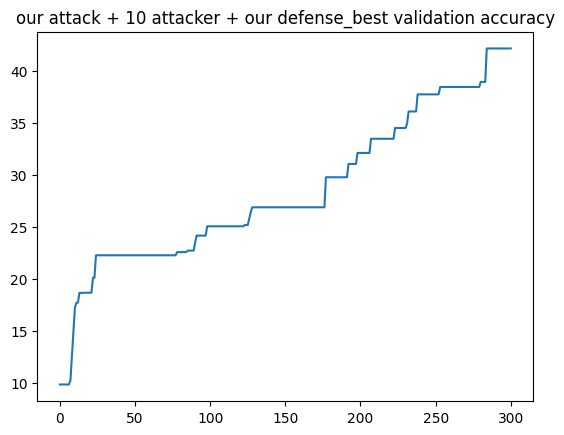

In [20]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./our attack + 40 attacker + no defense ' + col + '.png')
    plt.show()

## Execute no attack + our defense

In [21]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[0]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad ()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)
        for i in range(n_users):
            history[i].extend(updates_abs_mean[i])

        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no attack + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

discarded index []
epoch: 0, bulyan: at our-agr n_at 0 e 0 | val loss 2.3025 val acc 11.2622 best val_acc 11.262175


C:\Users\Hizan\AppData\Local\Temp\ipykernel_11040\1788414890.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


discarded index []
epoch: 1, bulyan: at our-agr n_at 0 e 1 | val loss 2.3018 val acc 11.9521 best val_acc 11.952110
discarded index []
epoch: 2, bulyan: at our-agr n_at 0 e 2 | val loss 2.3012 val acc 12.4797 best val_acc 12.479708
discarded index []
epoch: 3, bulyan: at our-agr n_at 0 e 3 | val loss 2.3006 val acc 11.7898 best val_acc 12.479708
discarded index []
epoch: 4, bulyan: at our-agr n_at 0 e 4 | val loss 2.3000 val acc 12.5406 best val_acc 12.540584
discarded index []
epoch: 5, bulyan: at our-agr n_at 0 e 5 | val loss 2.2993 val acc 12.3985 best val_acc 12.540584
discarded index []
epoch: 6, bulyan: at our-agr n_at 0 e 6 | val loss 2.2986 val acc 12.5812 best val_acc 12.581169
discarded index []
epoch: 7, bulyan: at our-agr n_at 0 e 7 | val loss 2.2979 val acc 12.6826 best val_acc 12.682630
discarded index []
epoch: 8, bulyan: at our-agr n_at 0 e 8 | val loss 2.2969 val acc 13.3117 best val_acc 13.311688
discarded index []
epoch: 9, bulyan: at our-agr n_at 0 e 9 | val loss 2.

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("no attack + our defense "+col)
    plt.savefig('./no attack + cour defense ' + col + '.png')
    plt.show()